# Laplace 2D with Dirichlet BCs

This tutorial will show you how to solve the Laplace equation in a square domain with dirichlet boundary conditions using a low-order panel method. 

Before we begin, make sure to import the following libraries.

In [12]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

The following functions 

- constantStrengthSource
- constantStrengthDoublet

calculate the induced velocity potential to a point $(x_{p}, y_{p})$ from a panel element with constant source (or dipole) distribution. The nodal coordinates of the panel element are $(x_{1}, y_{1}),(x_{2}, y_{2})$

In [13]:
def constantStrengthSource(x1, y1, x2, y2, xp, yp):
    # The induced velocity and velocity potential due to SL panel
    # At the centre of the element
    # curvilinear coordinate system
    xm=0.5*(x1+x2); ym=0.5*(y1+y2)
    xi1 = 0
    xi2 = math.sqrt((x2-x1)**2+(y2-y1)**2)

    fi = 2*xi2*math.log(0.5*xi2)/4/math.pi #potential
    th0 = math.atan2(y2-y1,x2-x1)
    rcon = math.sqrt((xp-xm)**2+(yp-ym)**2)/xi2

    if (rcon>1e-10):
        xip =  (xp-x1)*math.cos(th0)+(yp-y1)*math.sin(th0)
        yip = -(xp-x1)*math.sin(th0)+(yp-y1)*math.cos(th0)

        r1 = math.sqrt((xp-x1)**2+(yp-y1)**2)
        r2 = math.sqrt((xp-x2)**2+(yp-y2)**2)
        th1 = math.atan2(yip,xip-xi1)
        th2 = math.atan2(yip,xip-xi2)
        # The upper and lower side of the panels have the same fi (continuous)
        fi = (2*(xip-xi1)*math.log(r1) - 2*(xip-xi2)*math.log(r2) -2*(x2-x1) + 2*yip*(th2-th1))/4/math.pi

    return fi

def constantStrengthDoublet(x1, y1, x2, y2, xp, yp):
    xm=0.5*(x1+x2); ym=0.5*(y1+y2)
    xi1=0.0
    xi2=math.sqrt((x2-x1)**2+(y2-y1)**2)
    th0=math.atan2(y2-y1,x2-x1)

    xip =  (xp-x1)*math.cos(th0)+(yp-y1)*math.sin(th0)
    yip = -(xp-x1)*math.sin(th0)+(yp-y1)*math.cos(th0)
    fi=0.0
    rcon=math.sqrt((xp-xm)**2+(yp-ym)**2)/xi2;
    if (rcon>1e-10):
        th1=math.atan2(yip,xip-xi1);
        th2=math.atan2(yip,xip-xi2);
        fi=-(th2-th1)/2/math.pi;
        # the value changes if the solve the interior or exterior problem?
    return fi

def lineParametrization(xa, ya, xb, yb, Npanels):
    # line segment from point A to point B
    t = np.linspace(0,1,Npanels)
    xline = xa + t*(xb-xa)
    yline = ya + t*(yb-ya)
    return xline, yline

def collocationScheme(xi, yi):
    #normal and tangent unit vectors
    sizeN= len(xi)-1
    xcolloc = np.zeros(sizeN);ycolloc = np.zeros(sizeN)
    sin_theta = np.zeros(sizeN);cos_theta = np.zeros(sizeN)
    nx = np.zeros(sizeN);ny = np.zeros(sizeN)
    tx = np.zeros(sizeN);ty = np.zeros(sizeN)

    for ii in range(0,len(xcolloc)):
        xcolloc[ii] = 0.5*(xi[ii+1]+xi[ii])
        ycolloc[ii] = 0.5*(yi[ii+1]+yi[ii])

        lpanel = math.sqrt((xi[ii+1]-xi[ii])**2+(yi[ii+1]-yi[ii])**2) #panel length
        sin_theta[ii] = (yi[ii+1]-yi[ii])/lpanel
        cos_theta[ii] = (xi[ii+1]-xi[ii])/lpanel

        ## The normal vector outside the domain
        #nx[ii] = sin_theta[ii]
        #ny[ii] = -cos_theta[ii]
        #tx[ii] = -ny[ii]
        #ty[ii] = nx[ii]

        # The normal vector inside the domain
        nx[ii] = -sin_theta[ii]
        ny[ii] = cos_theta[ii]
        tx[ii] = ny[ii]
        ty[ii] = -nx[ii]

    return xcolloc, ycolloc, nx, ny, tx, ty

First thing we do, is to create the mesh. It is important to note that using bem instead of fmd or fem translates into a problem dimension reduction of 1. In that sense, for a 2d domain the mesh is actually the 1d boundary.

The sign convention for the normal vector as well as the boundary integral formulation is quite important. 

In [68]:
# CREATE MESH FOR SQUARE DOMAIN & BOYNDARY CONDITIONS
plotMesh = 1
plotBC = 1

Np = 5 #number of nodes
# square domain creation
xa, ya = 0, 0
xb, yb = math.pi, 0
xc, yc = math.pi, 1
xd, yd = 0, 1
[x1, y1] =lineParametrization(xa, ya, xb, yb, Np) #y=0
[x2, y2] =lineParametrization(xb, yb, xc, yc, Np) #x=pi
[x3, y3] =lineParametrization(xc, yc, xd, yd, Np) #y=1
[x4, y4] =lineParametrization(xd, yd, xa, ya, Np) #x=0

#nodes on the boundary with counter-clockwise numbering
xi = np.concatenate((x1, x2[1:len(x2)], x3[1:len(x3)], x4[1:len(x4)]))
yi = np.concatenate((y1, y2[1:len(y2)], y3[1:len(y3)], y4[1:len(y4)]))

The next step is to assign the boundary conditions to the collocation points, which are the mid-points of each panel element.

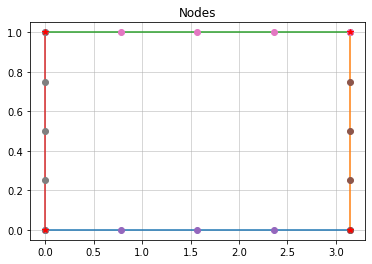

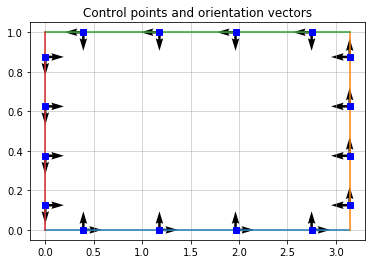

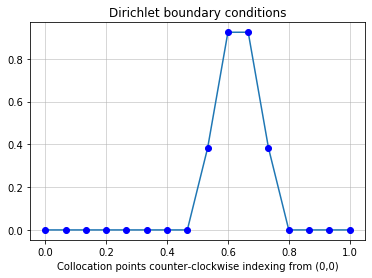

In [71]:
[xcolloc, ycolloc, nx, ny, tx, ty] = collocationScheme(xi, yi)
xcolloc3 = xcolloc[2*(Np-1):3*(Np-1)]
#Boundary conditions
#   D---------------C
#   -               -
#   -               -
#   A---------------B
u_bc1 = np.zeros(Np-1)       #[xa,ya] - [xb, yb]
u_bc2 = np.zeros(Np-1)       #[xb,yb] - [xc, yc]
u_bc3 = np.sin(xcolloc3)     #[xc,yc] - [xd, yd]
u_bc4 = np.zeros(Np-1)       #[xd,yd] - [xa, ya]
u_bc = np.concatenate((u_bc1, u_bc2, u_bc3, u_bc4))
xindex = np.linspace(0, 1, len(u_bc))

# plot the discretized domain
if (plotMesh==1):
    plt.plot(x1, y1, x2, y2, x3, y3, x4, y4)
    plt.plot(x1, y1, 'o', x2, y2, 'o', x3, y3, 'o', x4, y4, 'o')
    plt.plot(xa, ya, 'r*', xb, yb, 'r*', xc, yc, 'r*', xd, yd, 'r*')
    plt.grid(linestyle='-', linewidth=0.5)
    plt.title('Nodes')
    plt.show()

    plt.plot(x1, y1, x2, y2, x3, y3, x4, y4)
    plt.grid(linestyle='-', linewidth=0.5)
    plt.plot(xcolloc, ycolloc, 'bs')
    plt.quiver(xcolloc, ycolloc, nx, ny)
    plt.quiver(xcolloc, ycolloc, tx, ty)
    plt.grid(linestyle='-', linewidth=0.5)
    plt.title('Control points and orientation vectors')
    plt.show()


if (plotBC == 1):
    plt.plot(xindex, u_bc, xindex, u_bc, 'bo')
    plt.grid(linestyle='-', linewidth=0.5)
    plt.title('Dirichlet boundary conditions')
    strLabel = 'Collocation points counter-clockwise indexing from (' + str(xa) + ',' + str(ya) +')'
    plt.xlabel(strLabel);
    plt.show()

The boundary value problem is 

$ u_{xx} + u_{yy} = 0$, $x\in\Omega$ 

$ u(0,x)= 0, u(\pi, y) = 0$, $0<y<1$

$ u(x,0)= 0, u(x, 1) = \sin(x)$, $0<x<\pi$

The analytic solution of the BVP is given by the following formula  $u(x,y) = sinh(y)sin(x)/sinh(1)$



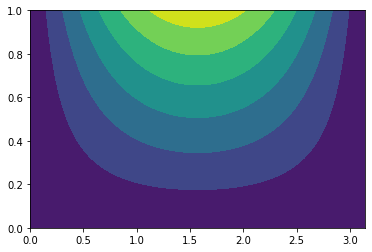

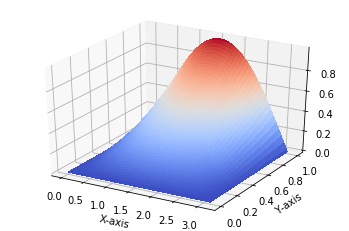

In [33]:
# ANALYTIC SOLUTION PREVIEW
plotAnalyticSolution = 1

if (plotAnalyticSolution==1):
    xanal = np.linspace(xa, xb, 100)
    yanal = np.linspace(ya, yc, 100)
    xx, yy = np.meshgrid(xanal, yanal)
    uanal = np.sinh(yy)*np.sin(xx)/math.sinh(1)
    plt.contourf(xx,yy,uanal)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, uanal, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    #ax.set_zlabel('Z axis')
    plt.show()

We build the linear system of equations, and solve to find the Neumann data or the directional derivative on the boundary. The boundary integral equation take the form

$\frac{1}{2} u + \int_{\partial\Omega} u \frac{\partial G}{\partial n} = \int_{\partial\Omega} G \frac{\partial u}{\partial n}$

and in discretized form

$\frac{1}{2} u_{i} + \sum_{j=1}^{i=Nc} u_{j} Bbij = \sum_{j=1}^{i=Nc} (\frac{\partial u}{\partial n})_{j} Abij$.

Particularly for the Dirichlet problem, the unknown is $(\frac{\partial u}{\partial n})_{j}$.

Whereas on the domain it holds that 

$u_{i} = - \sum_{j=1}^{i=Nc} u_{j} Bbij + \sum_{j=1}^{i=Nc} (\frac{\partial u}{\partial n})_{j} Abij$.

In [34]:
# BOUNDARY ELEMENT METHOD (BEM) BOYNDARY INTEGRAL EQUATION IN MATRIX FORM
sizeA = len(xcolloc)
Abij = np.zeros((sizeA, sizeA)) #G
Bbij = np.zeros((sizeA, sizeA)) #dGdn
#udirichlet = np.zeros((sizeA,1))
A = np.zeros((sizeA, sizeA))
S = np.zeros((sizeA, sizeA))

for ii in range(0, sizeA): #for each collocation point
    for jj in range(0, sizeA): #we evaluate the effect each panel
        # on each panel we have a piecewise-constat distribution of
        # sources (G) and dipoles (dG/dn)
        xp, yp = xcolloc[ii], ycolloc[ii]
        x1, y1 = xi[jj], yi[jj]
        x2, y2 = xi[jj+1], yi[jj+1]
        Abij[ii][jj] = constantStrengthSource(x1, y1, x2, y2, xp, yp)
        Bbij[ii][jj] = constantStrengthDoublet(x1, y1, x2, y2, xp, yp)
        deltaKronecker = 0
        if (ii == jj):
            deltaKronecker = 1
        A[ii][jj] = 0.5*deltaKronecker + Bbij[ii][jj]
        S[ii][jj] = Abij[ii][jj]

#===============================================================================
# SOLUTION OF THE LINEAR SYSTEM
b = np.matmul(A, u_bc)
dudn_bc = np.linalg.solve(S,b)

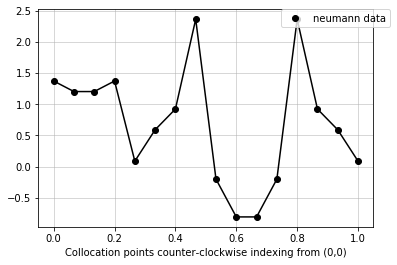

In [80]:
plotNumResultsBC = 1

# COMPARISON WITH THE ANALYTIC SOLUTION
if (plotNumResultsBC==1):
    """
    xindex = np.linspace(0, 1, len(xcolloc))
    plt.plot(xindex, u_bc)
    plt.plot(xindex, u_bc, 'bo', label='dirichlet data')
    strLabel = 'Collocation points counter-clockwise indexing from (' + str(xa) + ',' + str(ya) +')'
    plt.xlabel(strLabel);
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    plt.grid(linestyle='-', linewidth=0.5)
    plt.show()
    """
    
    plt.plot(xindex, dudn_bc, 'ko', label='neumann data')
    plt.plot(xindex, dudn_bc, 'k')
    strLabel = 'Collocation points counter-clockwise indexing from (' + str(xa) + ',' + str(ya) +')'
    plt.xlabel(strLabel);
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    plt.grid(linestyle='-', linewidth=0.5)
    plt.show()

From the boundary data, we predict the $u(x,y)$ in the square domain.

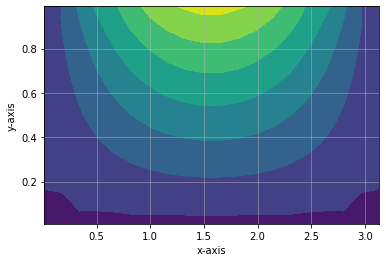

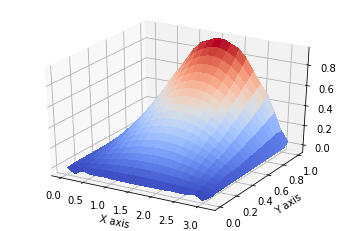

Number of elements = 60, maxError = 0.057860309302305214


In [46]:
plotNumericalSolution = 1

# DOMAIN SOLUTION u(x,y)
xtest = np.linspace(xa+0.01, xb-0.01, 20)
ytest = np.linspace(ya+0.01, yc-0.01, 20)
xnum, ynum = np.meshgrid(xtest, ytest)
uactual = np.sinh(ynum)*np.sin(xnum)/math.sinh(1)

unum = np.zeros((len(xtest), len(ytest)))

for kk in range(0, len(xtest)):
    for ll in range(0, len(ytest)):
        # for each point in the meshgrid
        utemporary = 0
        xp = xtest[ll]; yp = ytest[kk];
        for jj in range(0, len(xcolloc)):
            x1, y1 = xi[jj], yi[jj]
            x2, y2 = xi[jj+1], yi[jj+1]
            SL = constantStrengthSource(x1, y1, x2, y2, xp, yp) # (G)
            DL = constantStrengthDoublet(x1, y1, x2, y2, xp, yp) #(dG/dn)
            utemporary = utemporary + dudn_bc[jj]*SL - u_bc[jj]*DL

        unum[kk,ll]=utemporary

if (plotAnalyticSolution==1):
    plt.contourf(xtest,ytest,unum)
    plt.grid(linestyle='-', linewidth=0.5)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xnum, ynum, unum, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    #ax.set_zlabel('Z axis')
    plt.show()

totalError = np.max(np.abs(unum - uactual))
message1 = 'Number of elements = ' + str(4*Np) + ', maxError = ' + str(totalError)
print(message1)